# Tutorial on Wasserstien Flow Matching

Thank you for your interest in our work! Here we present a tutorial on how to run WFM for point-cloud generation.

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from wassersteinflowmatching import WassersteinFlowMatching

2024-10-06 22:47:50.549314: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Load Point Clouds

ShapeNet data can be downloaded from https://github.com/nv-tlabs/LION. Here we present generation based on airplane samples.

In [3]:
shape = 'airplane'

In [4]:
pc_train = np.load(f'data/pc_train_{shape}.npy')
pc_test = np.load(f'data/pc_test_{shape}.npy')



## Visualize them

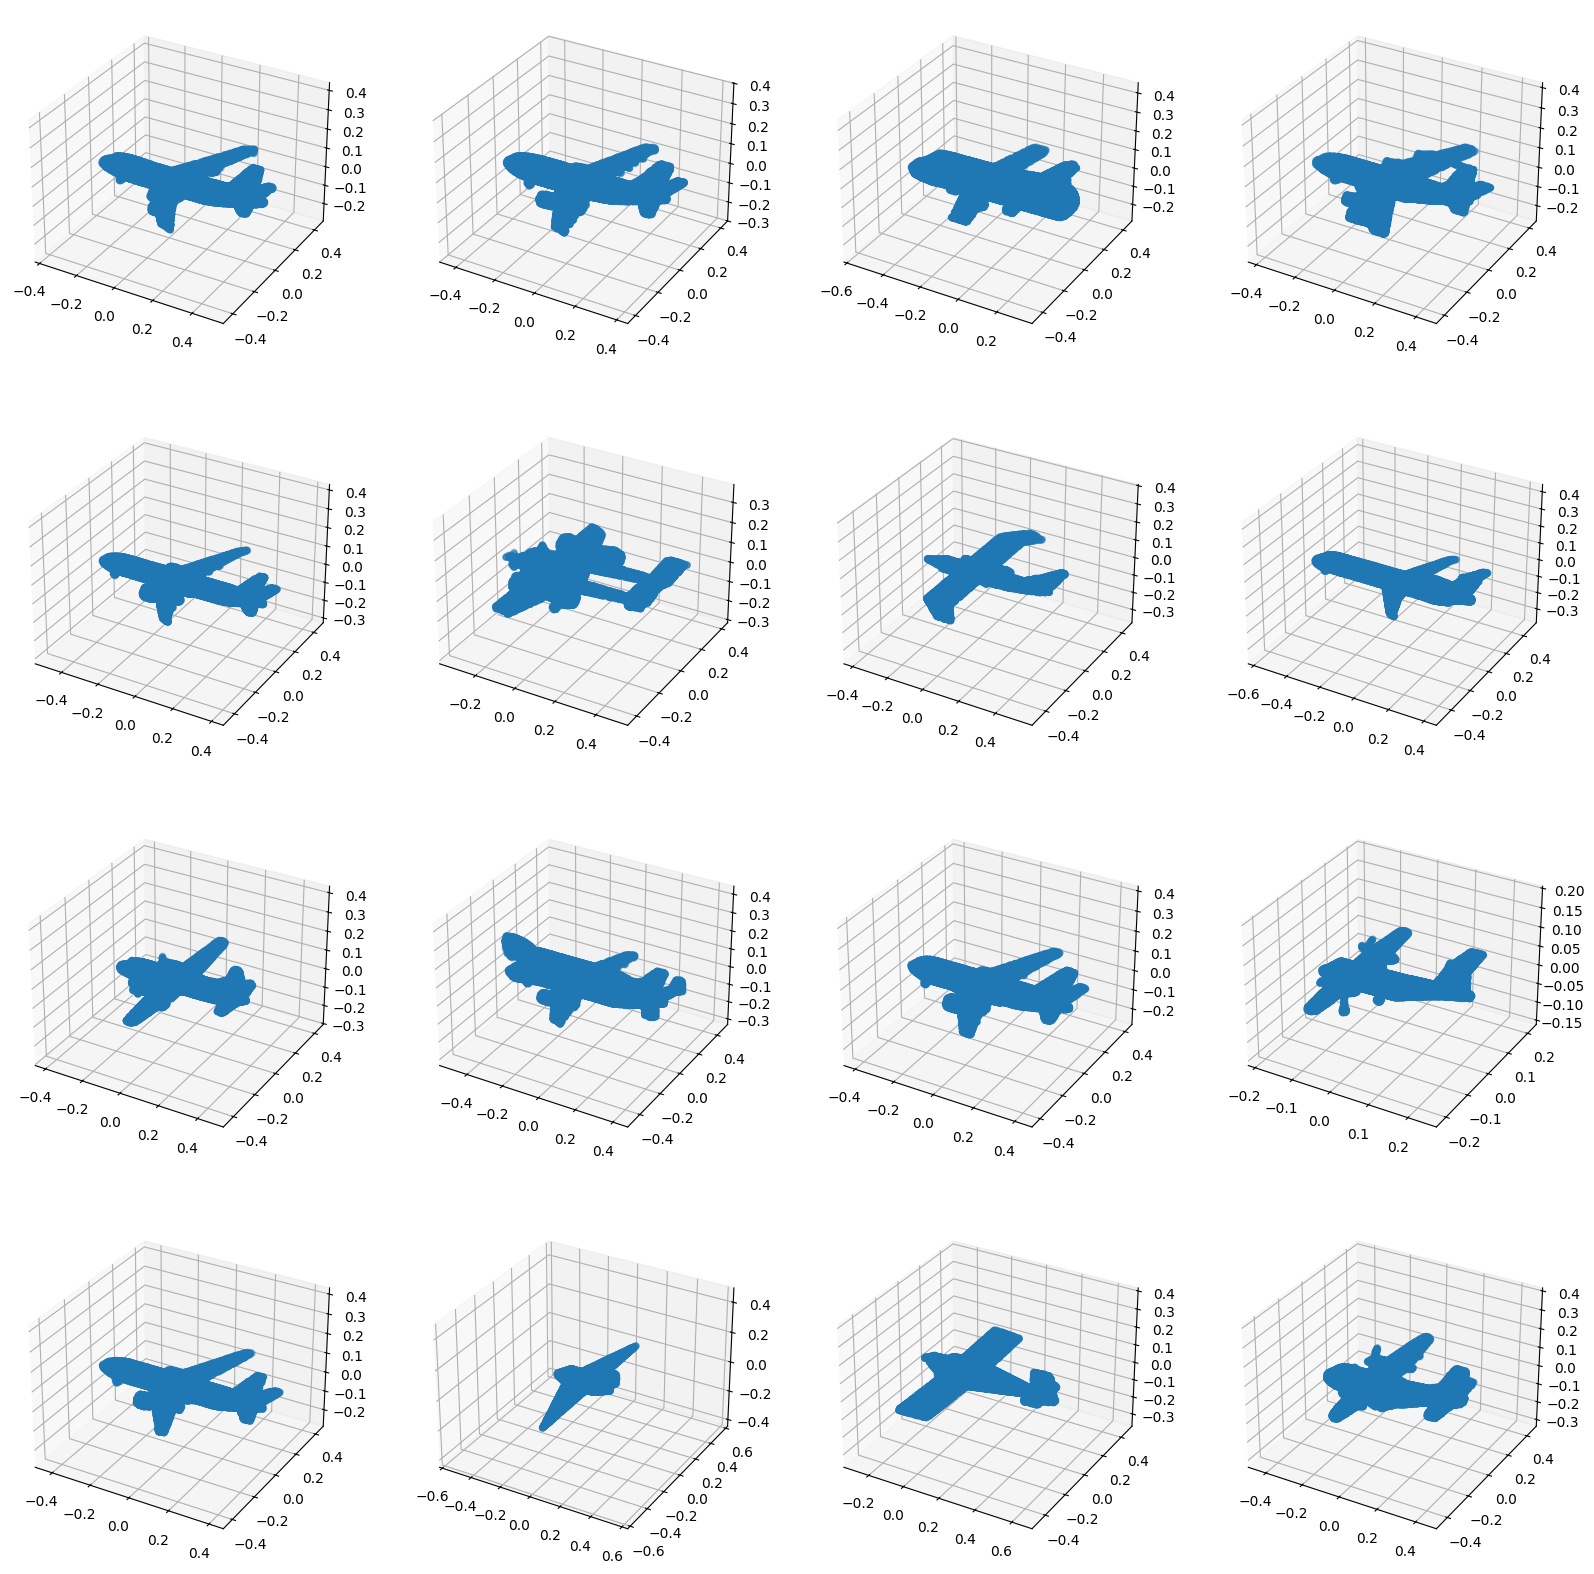

In [5]:
# plot the last point cloud in generated_samples in a 5 by 2 grid:
# 
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')
    i = np.random.randint(len(pc_train))
    ax.scatter((pc_train)[i][:, 2], -(pc_train)[i][:, 0], (pc_train)[i][:, 1])
    plt.axis('equal')
plt.show()

# Run Wasserstein Flow Matching

In [7]:
FlowMatchingModel = WassersteinFlowMatching(point_clouds = pc_train)

Using row_iter map with 200 iterations and 0.002 epsilon
Frechet Mini-Batch


Show source noise samples

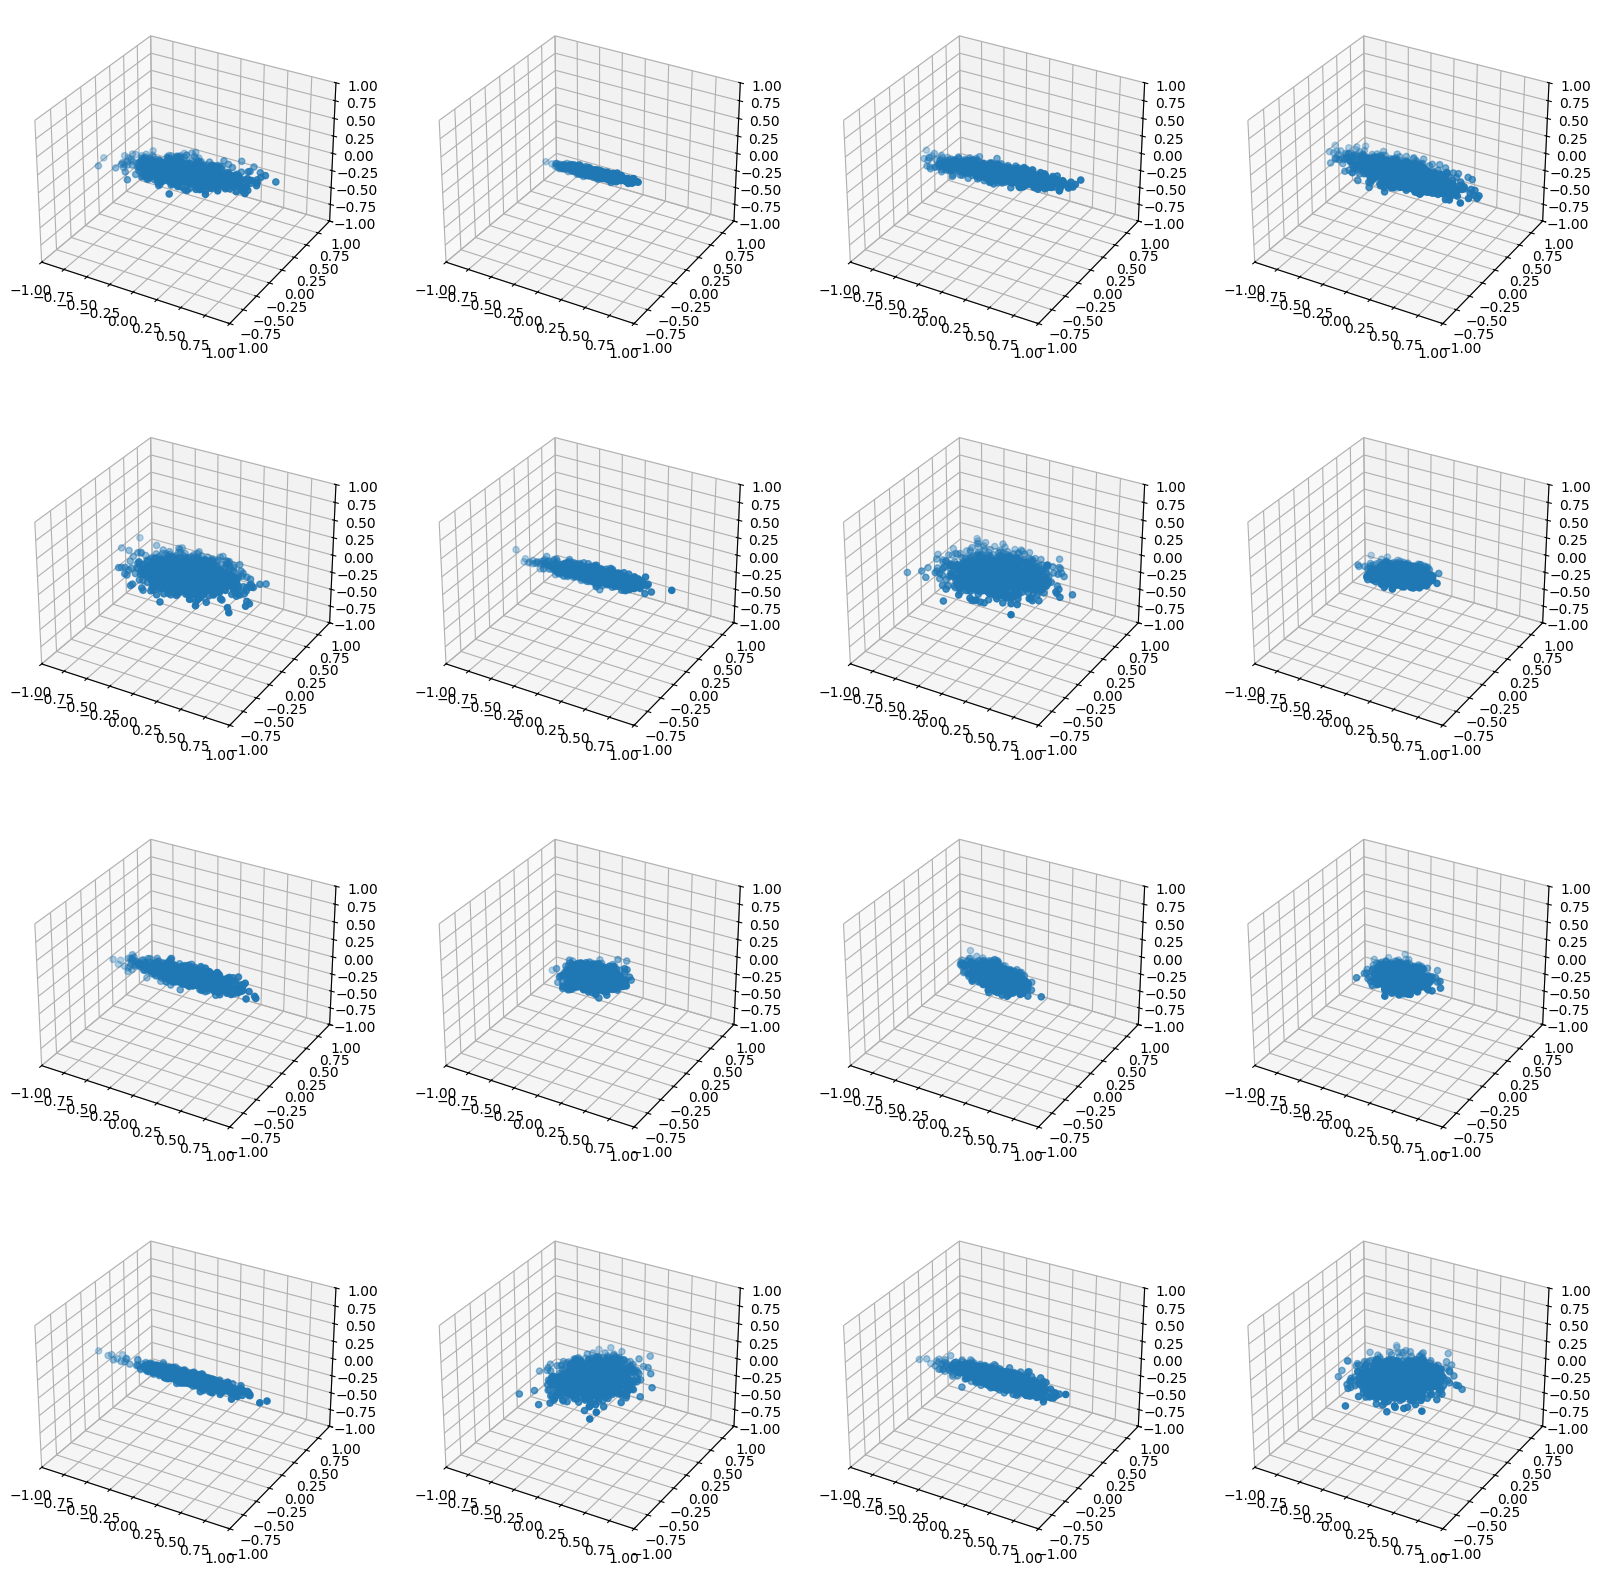

In [8]:

noise_samples = FlowMatchingModel.noise_func(size = [16, 1000, 3], noise_config = FlowMatchingModel.noise_config, key = jax.random.key(0))

fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')
    ax.scatter(noise_samples[ind][:, 2], -noise_samples[ind][:, 0], noise_samples[ind][:, 1])
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
plt.show()

Train Model & Plot loss curve

In [9]:

FlowMatchingModel.train(batch_size = 64, 
                        shape_sample = 1000, 
                        training_steps = 500000, 
                        decay_steps = 5000)

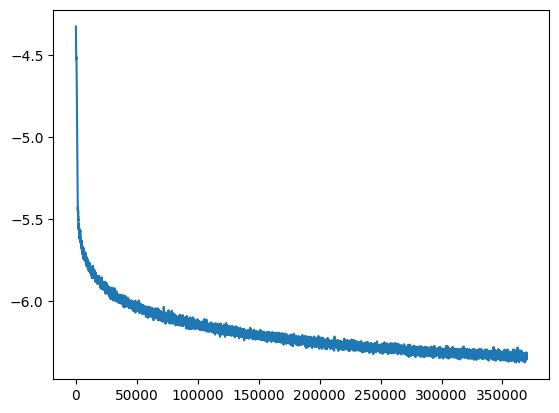

In [ ]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

# Generate Samples

Set Initial Key

In [10]:
key = jax.random.PRNGKey(0)

Run Flow for 1000 timesteps

In [11]:

subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples = 16,
                                                            size = 1000,
                                                            timesteps = 1000,
                                                            key = subkey)

100%|██████████| 1000/1000 [00:28<00:00, 34.96it/s]


Plot resulting point clouds

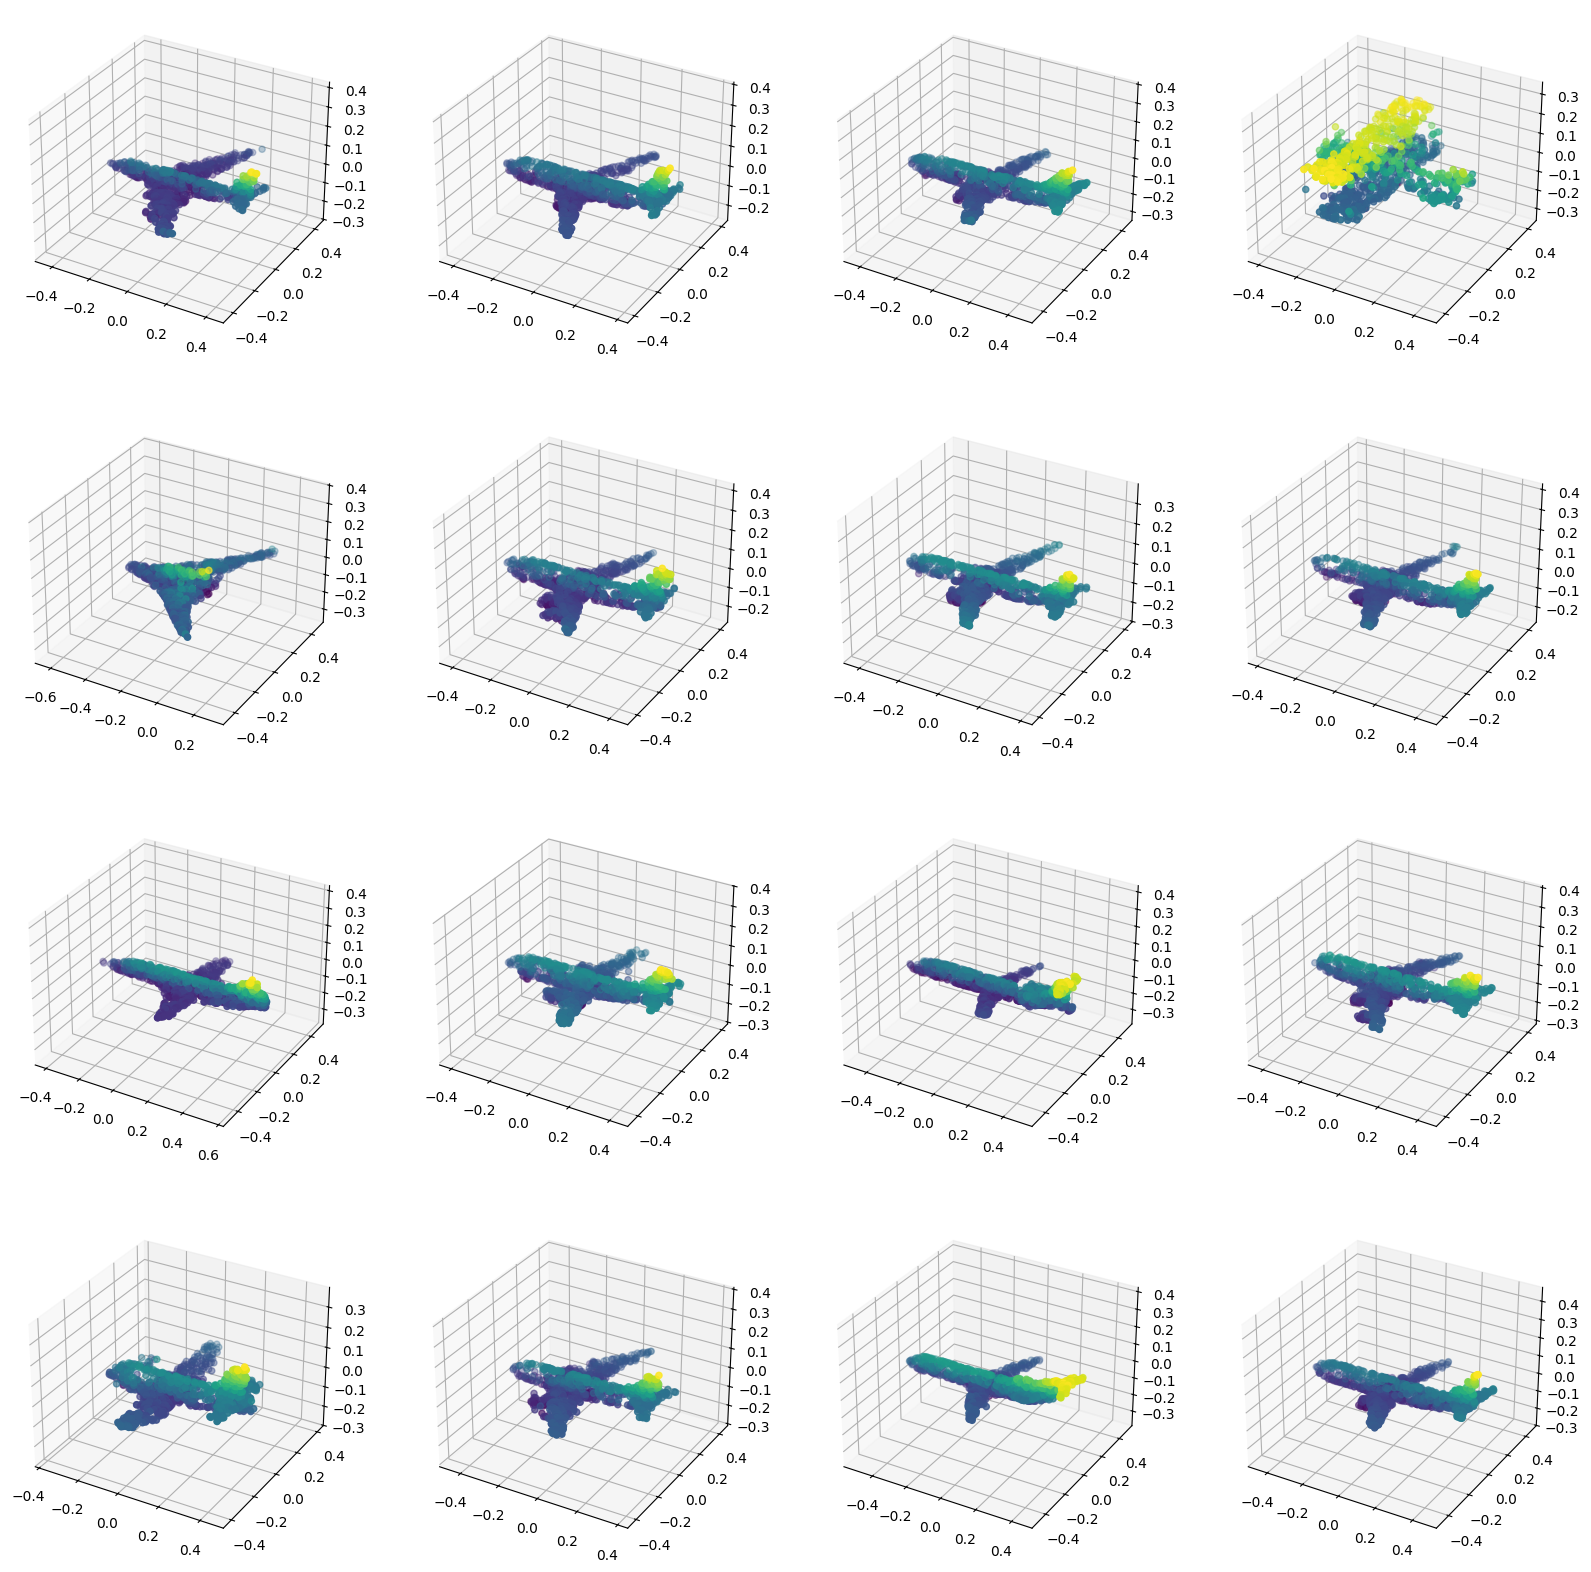

In [12]:
fig = plt.figure(figsize=(20, 20)) 
for i in range(16):
    ax = fig.add_subplot(4,4, 1+i, projection='3d')
    ax.scatter(generated_samples[-1][i][:, 2], - generated_samples[-1][i][:, 0],  generated_samples[-1][i][:, 1], c = generated_samples[-1][i][:, 1])
    ax.axis('equal')
plt.show()

# Generation Quality

Here we evalulate point-cloud generation based on 1-nearest-neighbour accuracy with test-set point-clouds. First, we generate point-clouds to match the test-size:

In [13]:
num_generate = pc_test.shape[0]
batch_size = num_generate//int(num_generate/200) + 1


In [14]:

generated_samples = []
for _ in range(num_generate//batch_size + 1):
    subkey, key = jax.random.split(key)
    generated_samples_batch, sample_weights = FlowMatchingModel.generate_samples(num_samples = batch_size,
                                                            size = 1000,
                                                            timesteps = 1000,
                                                            key = subkey)
    generated_samples_batch = generated_samples_batch[-1]
    generated_samples.append(generated_samples_batch)

generated_samples = np.concatenate(generated_samples, axis = 0)[:num_generate]

100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


Since generated point-clouds have 1000 points, we will first subsample the test set to match

In [15]:
pc_test_subsample = np.asarray([pc[np.random.choice(pc.shape[0], 1000, replace=False)] for pc in pc_test])

## Chamfer's Distance

Using jax-based acceleration, we will calculate the pairwise CD distance between all generated and test-set point_clouds

In [16]:
def chamfer_distance(px, py):
    pairwise_dist = jax.numpy.sum(jax.numpy.square(px[:, None, :] - py[None, :, :]), axis=-1)
    chamfer_dist = pairwise_dist.min(axis = 0).mean() + pairwise_dist.min(axis = 1).mean()
    return chamfer_dist

chamfer_batch = jax.jit(jax.vmap(chamfer_distance, in_axes=(0, 0), out_axes=0))

In [17]:
pointclouds_total = np.concatenate([generated_samples, pc_test_subsample]) # Concatenate the generated samples and the test point clouds to make batching easier
pointclouds_labels = np.concatenate([np.zeros(len(generated_samples)), np.ones(len(pc_test))]) # Create labels for accuracy calculation

tri_u_ind = np.stack(np.triu_indices(len(pointclouds_total), k=1)).T # Create indices for upper triangular matrix to avoid double counting
batch_size = 256 # Set batch size

Calculate pairwise CD distance and convert to distance matrix

In [18]:
pairwise_dist_cd = [chamfer_batch(pointclouds_total[batch_ind[:, 0]],
                                  pointclouds_total[batch_ind[:, 1]]) for batch_ind in np.array_split(tri_u_ind, len(tri_u_ind) // batch_size)]


In [19]:
dist_mat_cd = np.zeros((len(pointclouds_total), len(pointclouds_total)))
dist_mat_cd[tri_u_ind[:, 0], tri_u_ind[:, 1]] = np.concatenate(pairwise_dist_cd)
dist_mat_cd[tri_u_ind[:, 1], tri_u_ind[:, 0]] = np.concatenate(pairwise_dist_cd)



Calculate accuracy for Chamfer distance

In [20]:
cd_acc = np.mean(pointclouds_labels[dist_mat_cd.argsort(axis = 1)[:, 1]] == pointclouds_labels)

In [21]:
print('Chamfer distance accuracy: {:0.4f}'.format(cd_acc))

Chamfer distance accuracy: 0.7346


## EMD Distance

Using POT, we can also calculate the pairwise EMD matrix

In [22]:
from scipy.spatial.distance import cdist
from concurrent.futures import ProcessPoolExecutor
import itertools
import ot


In [23]:

def calculate_distance(pair):
    i, j = pair
    cost_matrix = cdist(pointclouds_total[i], pointclouds_total[j])
    return(ot.emd2([], [], cost_matrix))


def pairwise_point_cloud_distances(point_clouds, batch_size=256):
    N = len(point_clouds)
    distances = np.zeros((N, N))
    # Generate all pairs of indices
    pairs = list(itertools.combinations(range(N), 2))
    total_pairs = len(pairs)

    with ProcessPoolExecutor() as executor:
        for i in range(0, total_pairs, batch_size):
            batch = pairs[i:i+batch_size]
            results = list(executor.map(calculate_distance, batch))
            
            for (idx1, idx2), distance in zip(batch, results):
                distances[idx1, idx2] = distance
                distances[idx2, idx1] = distance  # Symmetric matrix


    return distances

In [24]:
dist_mat_emd = pairwise_point_cloud_distances(pointclouds_total)

Calculate accuracy for EMD

In [25]:
emd_acc = np.mean(pointclouds_labels[dist_mat_emd.argsort(axis = 1)[:, 1]] == pointclouds_labels)

In [26]:
print('EMD accuracy: {:0.4f}'.format(emd_acc))

EMD accuracy: 0.7173
